## Imports

In [1]:
import scipy.io, random
import numpy as np
from utils import *
import matplotlib.pyplot as plt

## Utils

In [2]:
def plot_forecast(source, prediction, nrow=5, ncol=5, from_=2800, to_=None):
    n = source.shape[0]
    idx = list(range(n))
    fig, axs = plt.subplots(nrow, ncol, figsize=(15,8), sharex=True)
    if to_ is None:
        to_ = source.shape[1]
    i = 0
    for r in range(nrow):
        for c in range(ncol):
            axs[r,c].plot(source[idx[i], from_:to_], c='b')
            axs[r,c].plot(prediction[idx[i], from_:to_], c='r')

            i += 1
    fig.tight_layout()
    plt.show()

In [3]:
def plot_shape_function(d, F1, F2, nrow=5, ncol=5):
    n = F1.shape[1]
    idx = random.sample(range(n), nrow * ncol)
    fig, axs = plt.subplots(nrow, ncol, figsize=(15,8), sharex=True)
    i = 0
    for r in range(nrow):
        for c in range(ncol):
            if F2 is not None:
                axs[r,c].scatter(d, F1[:, idx[i]], c='b')
                axs[r,c].scatter(d, F2[:, idx[i]], c='r')
            else:
                axs[r,c].scatter(d, F1[:, idx[i]])
            i += 1
    fig.tight_layout()
    plt.show()

In [4]:
## Colors
# import matplotlib.colors as mcolors
# size = out[2].shape[1]
# colors = list(mcolors.CSS4_COLORS.keys())
# indices = random.choices(range(len(colors)), k=size)

In [5]:
def scale(X, max_, min_):
    X_std = (X - X.min(axis=1).reshape(-1,1)) / ((X.max(axis=1) - X.min(axis=1)).reshape(-1,1))
    X_std = X_std * (max_ - min_) + min_
    return X_std

## Forecasting

In [51]:
sim = load_pickle('output/sim.pickle')

In [52]:
sim[2] = sim[2].detach().numpy()
sim[0].shape, sim[1].shape, sim[2].shape

((30, 500), (30, 500), (900, 1))

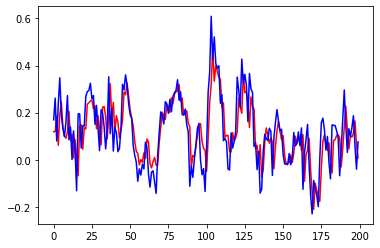

In [54]:
# plt.figure(figsize=(20,8))
plt.plot(sim[1][10, 300:500], c='r')
plt.plot(sim[0][10, 300:500], c='b')

plt.show()

In [ ]:
plot_forecast(sim[0], sim[1], 6, 5, 0, 500)

## Shape Function

In [9]:
_, d, _ = load_pickle('data/sample.pickle')

In [10]:
# d_norm = scale(d.reshape(1,-1), 1, 0).reshape(-1)
d_norm = d

In [11]:
F = np.log(d_norm+1)

In [12]:
d_norm.shape, sim[2].shape, F.shape

((900,), (900, 1), (900,))

In [ ]:
l = 0
plt.figure(figsize=(20,10))
plt.scatter(d_norm[:], F[:, ], c='b', label='estimated')
plt.scatter(d_norm[:], sim[2][:, l], c='r', label='actual')
plt.legend()
plt.show()

In [ ]:
plot_shape_function(d_norm, sim[2], None, 5, 5)

## Baselines Comparison

In [6]:
dataset = 'sim'

In [7]:
data = np.load(f'data/{dataset}.npy')
loc, n = data.shape

In [8]:
#  Scale data and horizon
# data = scale(data, 0.3, 0)

In [8]:
# Set horizon
horizon = 5

In [9]:
x_offsets = np.sort(np.concatenate((np.arange(1-horizon, 1, 1),)))
y_offsets = np.sort(np.arange(1, 1+horizon, 1))
x_ids, y_ids = [], []
min_t = abs(min(x_offsets))
max_t = abs(n - abs(max(y_offsets)))  # Exclusive
for t in range(min_t, max_t):
    x_ids.extend(t + x_offsets)
    y_ids.extend(t + y_offsets)

In [10]:
def aggregate(v, n=7320, h=20, loc=30):
    out = [np.zeros((1, loc)) for _ in range(n)]
    cnt = [np.ones((1, loc)) for _ in range(h)] + [np.zeros((1, loc)) for _ in range(n-h)]
    L = len(y_ids)
    for l in range(L):
        i = y_ids[l] 
        out[i] += v[l, :]
        cnt[i] += 1

    outs = np.concatenate(out)
    cnts = np.concatenate(cnt)
    return (outs/cnts).transpose()

In [19]:
def load_outputs(path, n, h, loc):
    data = np.load(path)
    input, pred, label = data['input'], data['prediction'], data['truth']
    
    
    if 'DC-RNN' in path:
        pred, label = pred.swapaxes(0,1), label.swapaxes(0,1)
        
    predictions = aggregate(pred.reshape(-1, loc), n, h, loc)
    labels = aggregate(label.reshape(-1, loc), n, h, loc)
    print(input.shape, pred.shape, label.shape, '//', predictions.shape, labels.shape)
    
    return predictions, labels

## Visualization

In [20]:
names = ['DC-RNN', 'FC-GAGA', 'GMAN', 'ConvLSTM']
preds = []
labels = []
for name in names:
    print(name)
    p, l = load_outputs(f'{name}/data/{dataset}/full_predictions.npz', n, horizon, loc)
    preds.append(p)
    labels.append(l)

DC-RNN
(5, 500, 30) (500, 5, 30) (500, 5, 30) // (30, 500) (30, 500)
FC-GAGA
(491, 30, 5, 1) (491, 30, 5) (491, 30, 5) // (30, 500) (30, 500)
GMAN
(491, 5, 30) (491, 5, 30) (491, 5, 30) // (30, 500) (30, 500)
ConvLSTM
(491, 5, 10, 3) (491, 5, 10, 3) (491, 5, 10, 3) // (30, 500) (30, 500)


In [22]:
i = 10

In [27]:
labels[0][i, 10], labels[1][i, 10], labels[2][i, 10], labels[3][i, 10]

(0.12433704733848572,
 0.034565917262807486,
 0.12433704733848572,
 0.124337048515311)

In [28]:
preds[0][i, 10], preds[1][i, 10], preds[2][i, 10], preds[3][i, 10]

(0.19487221539020538,
 0.14383842498064042,
 0.4346563994884491,
 0.5784735977649689)

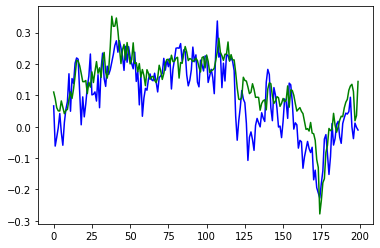

In [50]:
plt.plot(labels[1][i, 300:500], color='blue')
# plt.plot(preds[0][i, 300:500], color='red')
plt.plot(preds[1][i, 300:500], color='green')
# plt.plot(preds[2][i, 300:500], color='pink')
# plt.plot(preds[3][i, 300:500], color='black')